In [9]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, BatchNormalization, Conv2D, Dense, Flatten, Add
import numpy as np
from tensorflow.keras.datasets import mnist
import time

2.0.0


# Residual network for the MNIST dataset

#### Create a customized layer for the Residual Block

- Batch normalization
- ReLU activation function
- Conv2D layer with a 3x3 kernel, padding='SAME', and filters taken as input in the layer
- Batch normalization
- ReLU activation function
- Conv2D layer with a 3x3 kernel, padding='SAME', and same number of filters as the previous Conv2D layer

Create an "if clause" to check if the input and output last dimension are the same. If yes, add both in the return. If not, before adding apply to the inputs a shortcut projection: a Conv2D layer with a 1x1 kernel, padding='SAME', and same number of filters as the previous Conv2D layers


In [6]:
class ResidualBlock(Layer):

    def __init__(self,filters):
        super(ResidualBlock, self).__init__()
        
        self.bn_1 = BatchNormalization()
        self.bn_2 = BatchNormalization()
        self.conv_1 = Conv2D(filters, 3, padding='SAME')
        self.conv_2 = Conv2D(filters, 3, padding='SAME')
        self.conv_adjust_dim = Conv2D(filters, 1, padding='SAME')
        
    def call(self, inputs):
        x = self.bn_1(inputs, training=True)
        x = tf.nn.relu(x)
        x = self.conv_1(x)
        x = self.bn_2(x, training=True)
        x = tf.nn.relu(x) 
        x = self.conv_2(x)
        
        if x.shape[-1]==inputs.shape[-1]:
            return Add()([x,inputs])   # They need to have the same dimensions (filters add dimensions)
        else:            
            return Add()([x,self.conv_adjust_dim(inputs)])
    
ResLayer = ResidualBlock(filters=32)


#### Create a customized model that integrates the Residual Blocks

- Downsample with a Conv2d layer with 32 filters, 7x7 kernel and strides=2
- Apply a ResidualBlock with 32 filters
- Downsample with a Conv2d layer with 64 filters, 3x3 kernel and strides=2
- Apply a ResidualBlock with 64 filters
- Apply a flatten layer
- Apply a Dense layer with 10 units and softmax activation function

In [7]:
class MyModel(Model):

    def __init__(self):
        super(MyModel, self).__init__()
        self.Downsample_1 = Conv2D(32, 7, strides=2)
        self.Downsample_2 = Conv2D(64, 3, strides=2)
        self.ResBlock_1 = ResidualBlock(32)
        self.ResBlock_2 = ResidualBlock(64)
        self.Flatten = Flatten()
        self.DenseFinal = Dense(10, activation='softmax')
        
        
    def call(self, inputs):
        x = self.Downsample_1(inputs)
        x = self.ResBlock_1(x)
        x = self.Downsample_2(x)
        x = self.ResBlock_2(x)
        x = self.Flatten(x)
        x = self.DenseFinal(x)
        return x


model = MyModel()
x = tf.ones((1000,28,28,1))
print(model(x).shape)

model.summary()

(1000, 10)
Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           multiple                  1600      
_________________________________________________________________
conv2d_15 (Conv2D)           multiple                  18496     
_________________________________________________________________
residual_block_4 (ResidualBl multiple                  18752     
_________________________________________________________________
residual_block_5 (ResidualBl multiple                  74368     
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  16010     
Total params: 129,226
Trainable params: 128,842
Non-trainable params: 384
_____________________________________

#### Load the MNIST dataset

Do various preprocessing operations with it

In [10]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images[:5000,...]
train_labels = train_labels[:5000,...]
print(train_images.shape)

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

train_images /= 255
test_images /= 255
print('train_images shape:', train_images.shape)
print(train_images.shape[0], 'train samples')
print(test_images.shape[0], 'test samples')

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.batch(32)

#for x,y in train_dataset:
    
    #print(x.shape)
    #print(y.shape)
    #print(loss(x,y))
    #print(model(x).shape)
    #print(model(x)-y)
    

11493376/11490434 [==============================] - 0s 0us/step
(5000, 28, 28)
train_images shape: (5000, 28, 28, 1)
5000 train samples
10000 test samples


#### Define the optimizer 

Choose an Adam optimizer with learning rate of 0.001

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Define the loss function

As loss_object choose the SparseCategoricalCrossentropy

In [12]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(inputs, targets):
    return loss_object(targets, model(inputs))

#### Define the grad function

Add the `@tf.function` decorator

In [13]:
@tf.function
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

#### Define the customized training loop



In [14]:
from tensorflow.keras.utils import to_categorical

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 8

# Measure the training time
start_time = time.time()

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
 
    # Training loop
    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Compute current loss
        epoch_loss_avg(loss_value)  
        # Compare predicted label to actual label
        epoch_accuracy(to_categorical(y), model(x))

  # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                  epoch_loss_avg.result(),
                                                                  epoch_accuracy.result()))
    
print("Duration :{:.3f}".format(time.time() - start_time))

Epoch 000: Loss: 0.424, Accuracy: 91.660%
Epoch 001: Loss: 0.133, Accuracy: 97.840%
Epoch 002: Loss: 0.052, Accuracy: 99.520%
Epoch 003: Loss: 0.037, Accuracy: 99.820%
Epoch 004: Loss: 0.028, Accuracy: 99.880%
Epoch 005: Loss: 0.061, Accuracy: 99.720%
Epoch 006: Loss: 0.038, Accuracy: 99.920%
Epoch 007: Loss: 0.041, Accuracy: 99.800%
Duration :58.657


#### Check the model performance with the test dataset

In [15]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(32)

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

# Test loop
for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(x, y)
    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

# End epoch
print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 0.261
Test accuracy: 94.050%


#### Plot the loss and accuracy evolution throughout the epochs

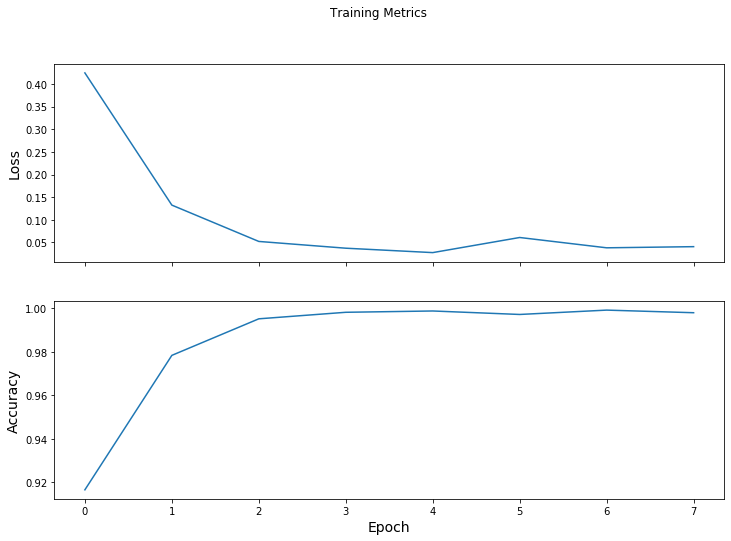

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Show an example of predicted label

In [17]:
print("Prediction: {}".format(np.argmax(model(train_images[1,...,np.newaxis].reshape(1,28,28,1)))))
print("     Label: {}".format(train_labels[1]))

Prediction: 0
     Label: 0
